# Peak over threshold method

This notebook details the peak-over-threshold method which is commonly used in analyzing sea level extremes. The goal of the peak-over-threshold method is to typically determine return levels (such as an extreme sea level which would occur only once a year or once every hundred years.

Contents:
* [Generate data](#Generate-data)
* [Select subset of extreme values](#Select-subset-of-extreme-values)
* [Fit extreme value distribution to extreme values](#Fit-extreme-value-distribution-to-extreme-values)
* [Determine return levels using CDF of fitted values](#Determine-return-levels-using-CDF-of-fitted-values)
* [Software packaging](#Software-packaging)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng(0)

## Generate data

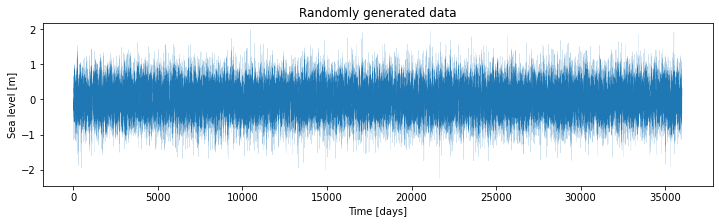

In [2]:
N = 36_000 # For example, for ~100 years of data
time = np.arange(N)
sea_level = rng.normal(scale=0.5, size=N)

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(time, sea_level, lw=0.1)
ax.set(
    title = 'Randomly generated data',
    xlabel='Time [days]',
    ylabel='Sea level [m]'
);

## Select subset of extreme values

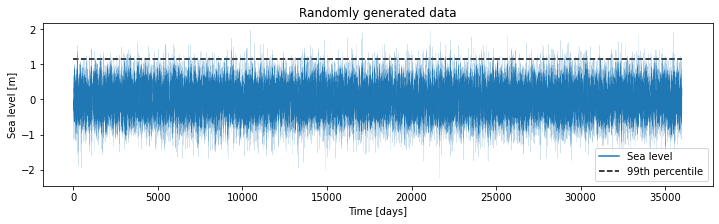

In [3]:
# Select subset of extreme values (those in the 95th percentile)
q = 0.99
quantile = np.quantile(sea_level, q)
extremes = sea_level[sea_level > quantile]

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(time, sea_level, lw=0.1, color='tab:blue')
ax.plot([],[], color='tab:blue', label='Sea level')    # Dummy plot for legend
ax.hlines(quantile, 0, N, ls='--', color='k', label='{}th percentile'.format(int(q*100)))
ax.set(
    title = 'Randomly generated data',
    xlabel='Time [days]',
    ylabel='Sea level [m]'
);
ax.legend();

## Fit extreme value distribution to extreme values

In [4]:
# Fit generalized pareto distribution to extreme values
from scipy.stats import genpareto

# Note: location parameter is set to the minimum of extremes.
# This implicitly assumes that we have enough data, and the
# distribution is concentrated towards lower values. However, 
# leaving out the `floc` parameter can result in poorly fitted
# MLE distributions to the data.
fitted_params = genpareto.fit(
    extremes,
    floc=np.min(extremes)
)
shape, loc, scale = fitted_params
print('Shape:\t', shape)
print('Loc:\t', loc)
print('Scale:\t', scale)

Shape:	 -0.12426650421504026
Loc:	 1.1640753622944915
Scale:	 0.18841523680473038


/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2282: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1059: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Try fiddling with kwargs to genpareto.fit. You can probably do better by manually setting the location and/or scale parameters to the extreme value data you have. Right now, the problem is with the shape parameter being less than -1, in which case the PDF is monotonically increasing on its compact support.

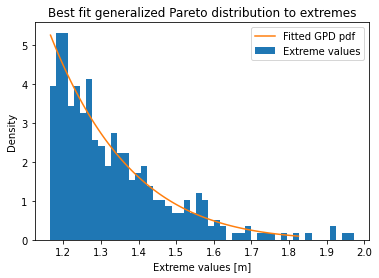

In [5]:
fig, ax = plt.subplots()
quantiles = np.linspace(
    genpareto.ppf(0.01, *fitted_params),
    genpareto.ppf(0.99, *fitted_params),
    99
)
fitted_pdf = genpareto.pdf(quantiles, *fitted_params)
ax.hist(extremes, bins=50, density=True, label='Extreme values')
ax.plot(quantiles, fitted_pdf, label='Fitted GPD pdf')
ax.set(
    title='Best fit generalized Pareto distribution to extremes',
    xlabel='Extreme values [m]',
    ylabel='Density'
);
ax.legend(loc='upper right');

## Determine return levels using CDF of fitted values

In [6]:
# 1-year return period
T = 365
p = 1/T
z_T = loc + scale/shape * (((1-q)/p)**shape - 1)
z_T

1.3894087358300535

In [7]:
# 10-year return period
T = 3650
p = 1/T
z_T = loc + scale/shape * (((1-q)/p)**shape - 1)
z_T

1.710630391570772

## Software packaging

In [8]:
import sys
sys.path.append('/Users/andrewbrettin/Tomfoolery/utils')
import pot

In [9]:
pot?

Type:        module
String form: <module 'pot' from '/Users/andrewbrettin/Tomfoolery/utils/pot.py'>
File:        ~/Tomfoolery/utils/pot.py
Docstring:  
Peak-over-threshold method

This module implements the peak-over-threshold method for univariate
data.

Available functions
-------------------
Computation:
- select_extremes(data, q=0.95)
- fit_distribution(extremes, fix_loc=True)
- return_level(data, return_period, q=0.95, fitted_params=None)

Plotting:
- plot_threshold(data, q, ax=None)
- plot_extreme_value_distribution(
    extremes, fitted_params=None, bins=50, ax=None
  )
- plot_return_level(return_period, fitted_params=None, ax=None)


/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2282: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1059: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2282: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1059: RuntimeWarning: invalid value encountered 

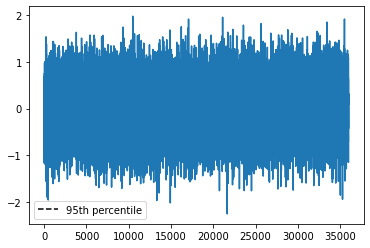

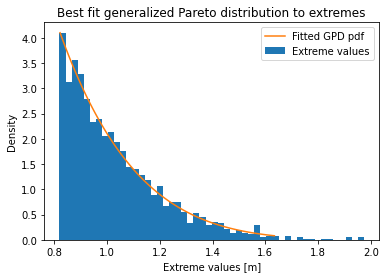

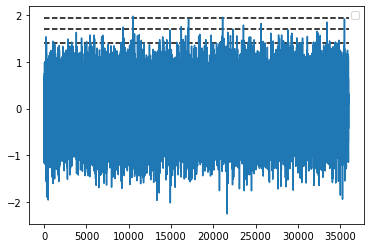

In [11]:
pot.plot_threshold(sea_level, q=0.95, alpha=1, s=1)

extremes = pot.select_extremes(sea_level, q=0.95)
pot.plot_extreme_value_distribution(extremes)

pot.plot_return_level(sea_level, [365, 3650, 36500])